In [1]:
words = open("names.txt", 'r').read().splitlines()

In [2]:
import torch

N = torch.zeros((27, 27), dtype=torch.int32)
chars = set(''.join(words))
s2i = {ch: i+1 for i, ch in enumerate(sorted(chars))}
s2i['.'] = 0
i2s = {i: ch for ch, i in s2i.items()}

for word in words:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word, word[1:]):
        N[s2i[ch1], s2i[ch2]] += 1

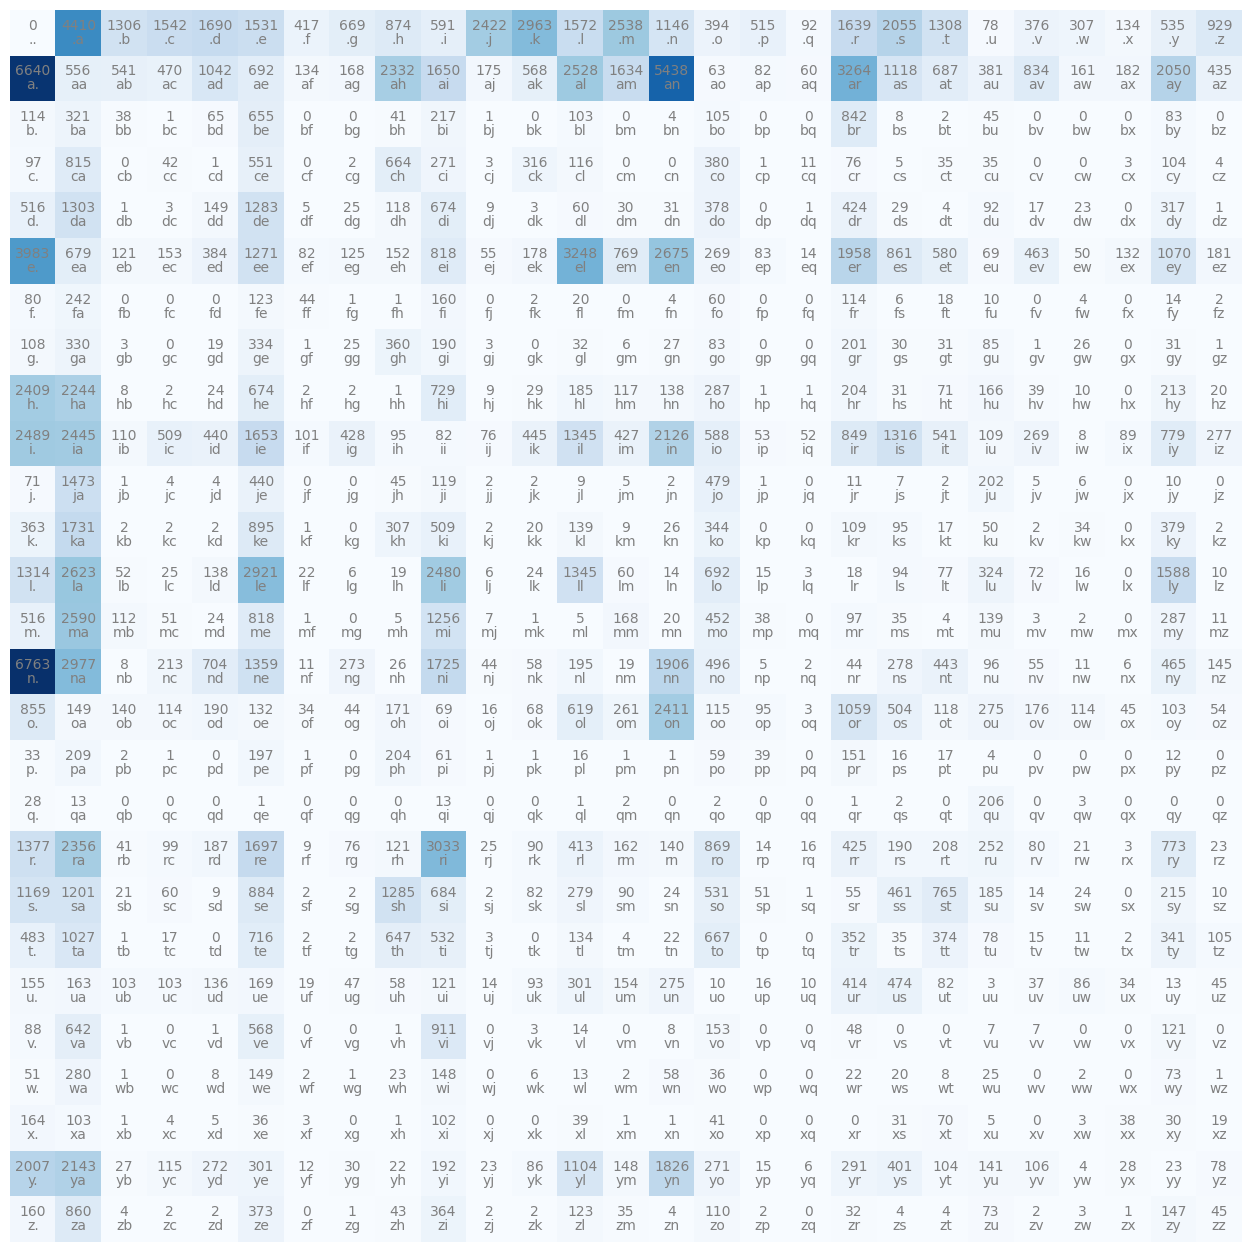

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

# heatmap
# plt.imshow(N, cmap='hot', interpolation='nearest')
def draw_bigram_tensor(N):
    plt.figure(figsize=(16, 16))
    plt.imshow(N, cmap='Blues')
    for i in range(27):
        for j in range(27):
            bigramstr = i2s[i] + i2s[j]
            plt.text(j, i, bigramstr, ha='center', va='top', color='grey')
            plt.text(j, i, N[i, j].item(), ha='center', va='bottom', color='grey')
    plt.axis('off')

draw_bigram_tensor(N)

In [116]:
P = N.float()
# MODEL SMOOTHING. Add low probability to unseen bigrams
P += 1
P /= P.sum(dim=1, keepdims=True)
assert torch.allclose(P.sum(dim=1), torch.tensor(1.0))

In [168]:

# generate
g = torch.Generator().manual_seed(2147483647)

def generateWord(probs): # probs is a 27x27 tensor
    word = ['.']
    while len(word) == 1 or word[-1] != '.':
        i = s2i[word[-1]]
        i = torch.multinomial(probs[i], 1, replacement=True, generator=g).item()
        word.append(i2s[i])
    return ''.join(word[1:-1])

gwords = [generateWord(P) for _ in range(10)]
print('\n'.join(gwords))

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda


In [118]:
# GOAL: Minimize likelihood of generated words w.r.t to model parameters (statistical modeling)
# equivalent to Maximizing the likelihood (since log is monotonic)
# equivalent to Minimizing the negative log likelihood
# equivalent to Minimizing the average negative log likelihood

log_likelihood = 0
ngrams = 0
for word in gwords:
    chars = ['.'] + list(word) + ['.']
    _ll = 0
    for ch1, ch2 in zip(chars, chars[1:]):
        _ll += torch.log(P[s2i[ch1], s2i[ch2]])
        ngrams += 1
    log_likelihood += _ll
    print(word, _ll.item())
    

log_likelihood /= ngrams
nll = -log_likelihood

nll


cexze -17.02704429626465
momasurailezitynn -45.49776077270508
konimittain -28.045055389404297
llayn -12.512446403503418
ka -5.085048198699951
da -6.016280174255371
staiyaubrtthrigotai -55.29625701904297
moliellavo -26.493249893188477
ke -5.749329566955566
teda -12.299741744995117


tensor(2.4600)

In [160]:
# neural network
xs, ys = [], []
for word in words:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word, word[1:]):
        xs.append(s2i[ch1])
        ys.append(s2i[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'number of elements {xs.nelement()}')

import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()

# Initialize the network i.e weights with random
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

number of elements 228146


In [ ]:
# gradient descent
for i in range(1000):
    ninputs = xs.nelement()
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = (xenc @ W) # log counts
    # softmax
    counts = logits.exp() # equivalent to N
    probs = counts / counts.sum(dim=1, keepdims=True)
    # loss: negative log likelihood
    loss = - probs[torch.arange(ninputs), ys].log().mean()
    print(loss.item())

    # backward pass
    W.grad = None # zero the gradient
    loss.backward()

    # update
    W.data -= 50 * W.grad

# Regularization. This would the bias towards the model smoothing. Similar to how we added +1 in the counting model above
# Approach 1: Instead of random weights. We can set the weights to be all 0. exp(0) = 1 i.e all bigrams are equally likely.
# W**2 is the L2 norm of the weights. It biases that the weights are closer to zero
# loss = - probs[torch.arange(ninputs), ys].log().mean() + 0.1 * W**2.mean()
# This regularization is like a spring that pulls the weights towards zero

3.185814142227173
3.0347607135772705
2.936236619949341
2.8658604621887207
2.813429117202759
2.7727489471435547
2.7400519847869873
2.713029146194458
2.6902244091033936
2.6706831455230713
2.653754711151123
2.6389708518981934
2.6259782314300537
2.6144979000091553
2.6043033599853516
2.5952064990997314
2.587050676345825
2.5797038078308105
2.573056936264038
2.567016363143921
2.5615041255950928
2.5564544200897217
2.551811695098877
2.5475282669067383
2.5435638427734375
2.5398850440979004
2.5364620685577393
2.5332705974578857
2.5302882194519043
2.527496576309204
2.524878978729248
2.52242112159729
2.5201098918914795
2.5179336071014404
2.5158817768096924
2.5139451026916504
2.5121147632598877
2.510383129119873
2.5087428092956543
2.507187604904175
2.505711317062378
2.5043087005615234
2.502974510192871
2.5017035007476807
2.500492811203003
2.499337673187256
2.498234510421753
2.4971799850463867
2.496171236038208
2.495205879211426
2.4942803382873535
2.4933929443359375
2.4925410747528076
2.4917223453521

In [169]:
# Generate probability distribution to match the one from the counting model
# forward pass
xs = torch.arange(27)
xenc = F.one_hot(xs, num_classes=27).float()
logits = (xenc @ W) # log counts
# softmax
counts = logits.exp() # equivalent to N
nnprobs = counts / counts.sum(dim=1, keepdims=True)

# generate
g = torch.Generator().manual_seed(2147483647)

gwords = [generateWord(nnprobs) for _ in range(10)]
print('\n'.join(gwords))

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda


In [7]:
# HW
# 1. Implement trigrams
N = torch.zeros((27, 27, 27), dtype=torch.int32)
chars = set(''.join(words))
s2i = {ch: i+1 for i, ch in enumerate(sorted(chars))}
s2i['.'] = 0
i2s = {i: ch for ch, i in s2i.items()}

for word in words:
    word = ['.', '.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
        N[s2i[ch1], s2i[ch2], s2i[ch3]] += 1


P = N.float()
# MODEL SMOOTHING. Add low probability to unseen trigrams
P += 1
P /= P.sum(dim=2, keepdims=True)
assert torch.allclose(P.sum(dim=2), torch.tensor(1.0))


# generate
g = torch.Generator().manual_seed(2147483647)

def generateWord(probs): # probs is a 27x27x27 tensor
    word = ['.', '.']
    while len(word) <= 2 or word[-1] != '.':
        i = s2i[word[-2]]
        j = s2i[word[-1]]
        k = torch.multinomial(probs[i, j], 1, replacement=True, generator=g).item()
        word.append(i2s[k])
    return ''.join(word[2:-1])

gwords = [generateWord(P) for _ in range(10)]
print('\n'.join(gwords))

# log likelihood
log_likelihood = 0
ngrams = 0
for word in gwords:
    chars = ['.', '.'] + list(word) + ['.']
    _ll = 0
    for ch1, ch2, ch3 in zip(chars, chars[1:], chars[2:]):
        _ll += torch.log(P[s2i[ch1], s2i[ch2], s2i[ch3]])
        ngrams += 1
    log_likelihood += _ll
    print(word, _ll.item())

log_likelihood /= ngrams
nll = -log_likelihood
nll


ce
bra
jalius
rochityharlonimittain
luwak
ka
da
samiyah
javer
gotai
ce -7.102407932281494
bra -6.705513954162598
jalius -14.094627380371094
rochityharlonimittain -53.899322509765625
luwak -13.829805374145508
ka -5.36928129196167
da -5.7427825927734375
samiyah -12.505107879638672
javer -10.684425354003906
gotai -17.249305725097656


tensor(2.1644)